In [ ]:
import os
import dask
import pathlib
import geopandas as gpd
from dask.distributed import Client
import src.inundation
from src.inundation import utils
from src.inundation.reservoirs_test import Dem, Vector, Dams, Collection, DemCollection, find_pointers

In [ ]:
# Specify paths to files
mother_directory = '/home/lepton/inundated_dams_27_oct_jojo/'

original_dams_shape_path = os.path.join(mother_directory,'dams','all_dams_replaced_refactored.shp')
raster_path = os.path.join(mother_directory,'nasa_mosiac','original_resolution.tif')
reduced_raster_path = os.path.join(mother_directory,'nasa_mosiac','dem_downscaled.tif')
modified_dams_shape_path = os.path.join(mother_directory,'IFC_locations','IFC_points.shp')
basins_dir = os.path.join(mother_directory,'sel_basin')
clipped_dem_path = os.path.join(mother_directory,'nasa_clipped_dem')
filled_dem_path = os.path.join(mother_directory,'nasa_clipped_dem_filled')
breached_dem_path = os.path.join(mother_directory,'nasa_clipped_dem_breached')
d8_dem_path = os.path.join(mother_directory,'nasa_clipped_dem_d8')
flow_acc_path = os.path.join(mother_directory,'nasa_clipped_dem_acc')
stream_dem_path = os.path.join(mother_directory,'nasa_clipped_dem_stream')
stream_vector_path = os.path.join(mother_directory,'nasa_clipped_dem_stream_shape')
dam_per_zone_path = os.path.join(mother_directory,'to_snap_pts')

# Set flags
reduce_dem = False # If true the original DEM will be reduced, otherwise the existing lower resolution 
                   # dem will be used
clip_dem = False
fill_dem = False
breach_dem = False
flow_acc = False
d8_dem = False
extract_streams = False
streams_to_vectors = False

# Calculation of inundation areas of reservoirs formed as a result of building new dams in Myanmar

## DEM PROCESSING

### Import dams shape with geopandas, trim, and save to a new file

In [ ]:
dams = gpd.read_file(original_dams_shape_path)
hutgyi_dam = dams[dams['DAM_NAME'] == 'Hutgyi']
dams = dams[(dams['Status 2']!='E') & (dams['RoR or Sto']=='S') & (dams['DAM_NAME']!='Suo Lwe')]
dams = dams.append(hutgyi_dam)
print(f'Data contains {len(dams)} planned/identified storage dams')
modified_dams_dir, modified_dams_file = os.path.split(modified_dams_shape_path)
pathlib.Path(modified_dams_dir).mkdir(parents=True, exist_ok=True)
dams.to_file(modified_dams_shape_path)
print(f'Saved new dam data to a file {modified_dams_file} in directory {modified_dams_dir}')

### Reduce the resolution of the raster DEM to speed-up calculation and reduce memory requirements

In [ ]:
if reduce_dem:
    dem = Dem(path=raster_path)
    dem.resize(new_path=reduced_raster_path, verbose=True)

### Split DEM of Myanmar into zones based on major basins
Suggested in https://www.esri.com/arcgis-blog/products/arcgis-desktop/mapping/some-best-practices-for-working-with-dems/abs

This code needs to be parallelized
https://github.com/dymaxionlabs/dask-rasterio/issues/3 but there an issue with serialization of rasterio objects *Rasterio datasets can't be pickled and can't be shared between processes or threads. The work around is to distribute dataset identifiers (paths or URIs) and then open them in new threads.* See rasterio/rasterio#1731

In [ ]:
if clip_dem:
    # Find shape files representing zones to clip DEM to
    zone_shapes = utils.find_files(path=basins_dir, ext='.shp')
    # Initialize DEM and clip it to zones
    dem = Dem(path=reduced_raster_path)
    dem.clip_to_polygons(
        zones=Collection([Vector(shape) for shape in zone_shapes]),
        clipped_path=clipped_dem_path)

## WATERSHED DELINEATION

The script is adopted from the paper https://servir.adpc.net/sites/default/files/public/tools/attachments/GIS-based%20web%20platform%20for%20reservoir%20inundation%20mapping.pdf

## Workflow
Watershed delineation for each dam locations
   1. Fill and breach raster (DEM)
   2. Calculate flow accumuation and D8 pointer
   3. Stream extraction (this stems from DEM data we used , so no other ready-made data can be used unless there is data homogeniety.
   4. Find dams locations depending on each master zone (Ayeyarwaddy,Salweem, Sittaung, etc)
   5. Find snapped points (i.e. actually hydrological correct points which stems from DEM we used)
   6. Waterhshed extraction for each points. (there is no DEM info here; which leads to the steps below)
   7. Raster to shape for extracted watersheds.
   8. Clip master-zone DEMs by shapes of extracted watersheds.
   9. Implement inundated area algorithm.
   10. Raster to shape operation for extracted inundated area which was in raster.
   11. Other ad hoc tasks

### Fill and Breach DEM

In [ ]:
if fill_dem:
    dem_col = DemCollection()
    dem_col.from_path(clipped_dem_path)
    dem_col.fill(output_path=filled_dem_path)

In [ ]:
if breach_dem:
    dem_col = DemCollection()
    dem_col.from_path(filled_dem_path)
    dem_col.breach(output_path=breached_dem_path)

### Generate a flow pointer grid using D8 algorithm

In [ ]:
d8_dem = True
if d8_dem:
    dem_col = DemCollection()
    dem_col.from_path(breached_dem_path)
    dem_col.d8_pointer(output_path=d8_dem_path)

### Flow accumulation

In [ ]:
flow_acc = True
if flow_acc:
    dem_col = DemCollection()
    dem_col.from_path(d8_dem_path)
    dem_col.accumulate(output_path=flow_acc_path)

### Stream extraction

<span style="color:red">**NOTE:**</span> Catchment delineation is sensitive to stream order which is a parameter for the stream extraction algorithm

In [ ]:
if extract_streams:
    dem_col = DemCollection()
    # Initialize with flow accumulation rasters
    dem_col.from_path(flow_acc_path)
    dem_col.extract_streams(output_path=stream_dem_path, stream_order=8)

In [ ]:
streams_to_vectors = True
if streams_to_vectors:
    dem_col = DemCollection()
    dem_col.from_path(stream_dem_path)
    # Create a d8_flow_pntr_list (decided for now to leavt this out of classes and have it as a separate
    # library function)
    d8_flow_pntr_list = find_pointers(dem_names=dem_col.paths, pointer_path=d8_dem_path)
    # Convert raster streams to vectors
    dem_col.stream_to_vec(output_path=stream_vector_path, d8_flow_pntr_list=d8_flow_pntr_list)

### Dam locations
Some dam locations in the IFC database that is the main and only source of information about dams for the Myanmar case study in FutureDAMS are different from  https://damtool-servir.adpc.net/ . Nevetheless the difference are not large enough to have a significant effect on reservoir area estimates compared to those obtained using IFC data on dams

### Divide dam shape file into zones

In [ ]:
dams = Dams(path=modified_dams_shape_path)
dams.divide_to_zones(path_to_zone_shapes=basins_dir, output_path=dam_per_zone_path)

### Snap dams to nearest streams

### stream_order (8 picked here) is one of the sensitive paratmeters as lower streamorder is prone to smaller upstream catchment and vice versa. There is no one-size-fit-all solution here as we are not individually looking at each dams  Other sensitive paramters include
- dam height
- dam locations
- I do not think the DEM raster resolution has much sensitivity for the ouput (maximum reservoir/inundated area); maybe for the volumne curve

In [ ]:
watershed extraction, inundated area

In [ ]:
pts_list = [os.path.join(mother_directory,'to_snap_pts',i) for i in [i for i in os.listdir(os.path.join(mother_directory,'to_snap_pts')) if '.shp' in i[-4:]]]

In [ ]:
pts_dict = {}
for zone in range(len(zone_name)):
    pts_dict[zone_name[zone]] = pts_list[zone]
pts_dict

### The following code finds snapped points of existing dams locations to nearest streams
- stream_order matters

- dam locations matters; regarding thier impact on the outputs (inundated area etc)

In [ ]:
# snap_dist = 0.6, if the points are not snapping right please change (mostly increase) the value; be aware
# that 1 means 100 km
def snap_pour_pts(pour_pts,streams,pts_dict,stream_dict) -> None:
    """snapp the existing dam locations to nearest streams"""
    Path(os.path.join(mother_directory,'nasa_snapped_pts')).mkdir(parents=True, exist_ok=True)
    remove_file(os.path.join(mother_directory,'nasa_snapped_pts',pour_pts+'.shp'))
    wbt.jenson_snap_pour_points(pour_pts = pts_dict[pour_pts],
                                streams = stream_dict[streams],
                                output = os.path.join(mother_directory,'nasa_snapped_pts',pour_pts+'.shp'),
                                snap_dist = 0.6) #careful with this! Know the units of your data

In [ ]:
%%time
snap_compute_list = []
for pour_pts,streams in zip(pts_dict.keys(),stream_dict.keys()):
    print(pour_pts,streams)
    
    z  = delayed(snap_pour_pts)(pour_pts,streams,pts_dict,stream_dict)
    snap_compute_list.append(z)

In [ ]:
%%time 
dask.compute(*snap_compute_list)

In [ ]:
snapped_pts = [os.path.join(mother_directory,'nasa_snapped_pts',i) for i in [i for i in os.listdir(os.path.join(mother_directory,'nasa_snapped_pts')) if '.shp' in i[-4:]]]

In [ ]:
snapped_pts

### Combine all stream / snapped points shapefiles into one file and geojsonize it to display it in folium    

In [ ]:
%%time
#combine stream shapefiles
folder = Path(os.path.join(mother_directory,'nasa_clipped_dem_stream_shape'))
shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
#gdf.index = [int(i[:-4]) for i in os.listdir(folder) if '.shp' in i]
#gdf = gdf.set_crs({'init': 'epsg:4326'}) # change projection
gdf = gdf.set_crs('epsg:4326') # change projection
Path(os.path.join(mother_directory,'nasa_clipped_dem_masterstream_shape')).mkdir(parents=True, exist_ok=True)
remove_file(os.path.join(mother_directory,'nasa_clipped_dem_masterstream_shape','master_stream.shp'))
gdf.to_file(os.path.join(mother_directory,'nasa_clipped_dem_masterstream_shape','master_stream.shp'))
gdf['STRM_VAL']

In [ ]:
%%time
#combine snapped shapefiles
folder = Path(os.path.join(mother_directory,'nasa_snapped_pts'))
shapefiles = folder.glob("*.shp")
gdf_snapped = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
#gdf.index = [int(i[:-4]) for i in os.listdir(folder) if '.shp' in i]
#gdf = gdf.set_crs({'init': 'epsg:4326'}) # change projection
gdf_snapped = gdf_snapped.set_crs('epsg:4326') # change projection
Path(os.path.join(mother_directory,'nasa_clipped_dem_mastersnapped_shape')).mkdir(parents=True, exist_ok=True)
remove_file(os.path.join(mother_directory,'nasa_clipped_dem_mastersnapped_shape','master_snapped.shp'))
gdf_snapped.to_file(os.path.join(mother_directory,'nasa_clipped_dem_mastersnapped_shape','master_snapped.shp'))

In [ ]:
gdf_snapped

In [ ]:
%%time
##shape to geogson for master stream
remove_file(os.path.join(mother_directory,'nasa_clipped_dem_masterstream_shape','master_stream.geojson'))
shapefile2geojson(os.path.join(mother_directory,'nasa_clipped_dem_masterstream_shape','master_stream.shp'),
                  os.path.join(mother_directory,'nasa_clipped_dem_masterstream_shape','master_stream.geojson'),
                  'STRM_VAL')
##shape to geogson for master snapped pts
remove_file(os.path.join(mother_directory,'nasa_clipped_dem_mastersnapped_shape','master_snapped.geojson'))
shapefile2geojson(os.path.join(mother_directory,'nasa_clipped_dem_mastersnapped_shape','master_snapped.shp'),
                  os.path.join(mother_directory,'nasa_clipped_dem_mastersnapped_shape','master_snapped.geojson'),
                  'ID')

In [ ]:
%%time
##shape to geogson for IFC locations
remove_file(os.path.join(os.path.join(mother_directory,'IFC_locations','IFC_points.geojson')))
shapefile2geojson(os.path.join(mother_directory,'IFC_locations','IFC_points.shp'),
                  os.path.join(mother_directory,'IFC_locations','IFC_points.geojson'),
                  'ID')

In [ ]:
%%time
##myanmar river GOIDS; to compare with our extracted stream
remove_file(os.path.join(mother_directory,'Myanmar_rivers','Myanmar_rivers.geojson'))
shapefile2geojson(os.path.join(mother_directory,'Myanmar_rivers','Myanmar_rivers.shp'),
                  os.path.join(mother_directory,'Myanmar_rivers','Myanmar_rivers.geojson'),
                  'STRM_VAL')

In [ ]:
# NOTE:
# HydroRivers were obtained from a DEM with lesser resolution than Southampton's river network but
# include streams of lower orders (smaller streams) than the Southampton's network

In [ ]:
%%time

style1 = {'fillColor': '#228B22', 'color': '#228B22','weight':0.9}
style2 = {'fillColor': '#00FFFFFF', 'color': '#00FFFFFF','weight':0.9}
style3 = {'fillColor': '#0000FF', 'color': '#0000FF','weight':1.5}
style4 = {'fillColor': '#000000', 'color': '#000000','weight':1.5}

#Define coordinates of where we want to center our map
boulder_coords = [21, 97]

#Create the map
my_map = folium.Map(location = boulder_coords, zoom_start = 6)
folium.GeoJson(os.path.join(mother_directory,'nasa_clipped_dem_masterstream_shape','master_stream.geojson'),
              style_function=lambda x:style1).add_to(my_map)
"""IFC points"""
folium.GeoJson(os.path.join(mother_directory,'IFC_locations','IFC_points.geojson'),
              style_function=lambda x:style3,name='IFC').add_to(my_map)
"""Snapped points"""
folium.GeoJson(os.path.join(mother_directory,'nasa_clipped_dem_mastersnapped_shape','master_snapped.geojson'),
              style_function=lambda x:style4,name='snapped').add_to(my_map)

"""turn on the following code to compare or do it in QGIS as the notebook may crush"""
# folium.GeoJson(os.path.join(mother_directory,'Myanmar_rivers','Myanmar_rivers.geojson'),
#               style_function=lambda x:style2).add_to(my_map)
# folium.TileLayer(
#     tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
#     attr="USGS - The National Map",
#     name="USGS - The National Map - Topo",
#     show=True
# ).add_to(my_map)
#Display the map
my_map
print('Zoom in and out;;;')

#### Whitebox tools can find the contributing upstream catchment given many points, but the weakness is that the extent of catchment for the lowest snapped points stopped at the adjacent upper snapped points. This matters if the inundated area stretched far beyond the adjacent upper snapped point. But finding catchment for individual point is computationally expensive. 
- most of dam inundations are not overlapped. 
- I have given only individual-based method. 
- Alternative is to reduce the resolution of original DEM raster data if wanna find upstream catchment using individual points.

In [ ]:
def shp_individual(df,ID,zone):
    #ID_1 = copy.deepcopy(ID) ### advoid global state?
    df_ = df[df.ID==ID]#df_ = df[df.ID==ID_1]
    remove_file(os.path.join(mother_directory,'individual_snapped_pts',zone,str(ID)+'.shp'))
    Path(os.path.join(mother_directory,'individual_snapped_pts',zone)).mkdir(parents=True, exist_ok=True)
    to_save = os.path.join(mother_directory,'individual_snapped_pts',zone,str(ID)+'.shp')
    df_.to_file(to_save)
    return to_save

In [ ]:
zone_dict

In [ ]:
zone_snapped_pts = [os.path.join(mother_directory,'nasa_snapped_pts',i) for i in 
                                [i for i in os.listdir(os.path.join(mother_directory,'nasa_snapped_pts')) if '.shp' in i[-4:]]]
zone_snapped_pts_dict = {}
for zone in range(len(zone_name)):
    zone_snapped_pts_dict[zone_name[zone]] = zone_snapped_pts[zone]
zone_snapped_pts_dict

In [ ]:
%%time
for zone in zone_snapped_pts_dict:
    print(zone)
    df = gpd.read_file(zone_snapped_pts_dict[zone])
    
    for ID in df.ID:
        print(ID)
        shp_individual(df,ID,zone)

In [ ]:
d8_ptr_dict = {}
for zone in range(len(zone_name)):
    d8_ptr_dict[zone_name[zone]] = d8_ptr_list[zone]
d8_ptr_dict


In [ ]:
def watershed_individual(d8_pntr,snapped_pts,zone,number):
    """find upper catchment/watershed based on a snapped point or list of snapped points;
    If using the list of points at once, please set snapped_pts as zone_based pts rather than individual points"""
    remove_file(os.path.join(mother_directory,'individual_watershed',zone,zone+'_'+str(number)+'.tif'))
    Path(os.path.join(mother_directory,'individual_watershed',zone)).mkdir(parents=True, exist_ok=True)
    
    wbt.watershed(d8_pntr = d8_pntr,
              pour_pts = snapped_pts,
              output = os.path.join(mother_directory,
                                    'individual_watershed',zone,zone+'_'+str(number)+'.tif'))
    
    return os.path.join(mother_directory,'individual_watershed',zone,zone+'_'+str(number)+'.tif')

In [ ]:
individual_snapped_pts_dict = {}
for zone in zone_name:
    zone_dict = {}
    #print(zone)
    for number in [i for i in os.listdir(os.path.join(mother_directory,'individual_snapped_pts',zone)) if '.shp' in i[-4:]]:
        #print(number)
        zone_dict[number[:-4]] = os.path.join(mother_directory,'individual_snapped_pts',zone,number)
    individual_snapped_pts_dict[zone] = zone_dict
individual_snapped_pts_dict

### the following code is the biggest bottleneck computationally. The reason Whitebox might be quicker using list of points rather than individual points is that they might share the same d8_pntr. The source code fo Whitebox is written in "Rust". 
### I found running the next cell without DASK module, is even faster (both individual points and list of points)

## Whitebox tool is pretty optimized anyway, adopting parallel computig whenerver possible accoding to the author of whitebox.
- the follwing screen shot is without using DASK with all cores being used up.
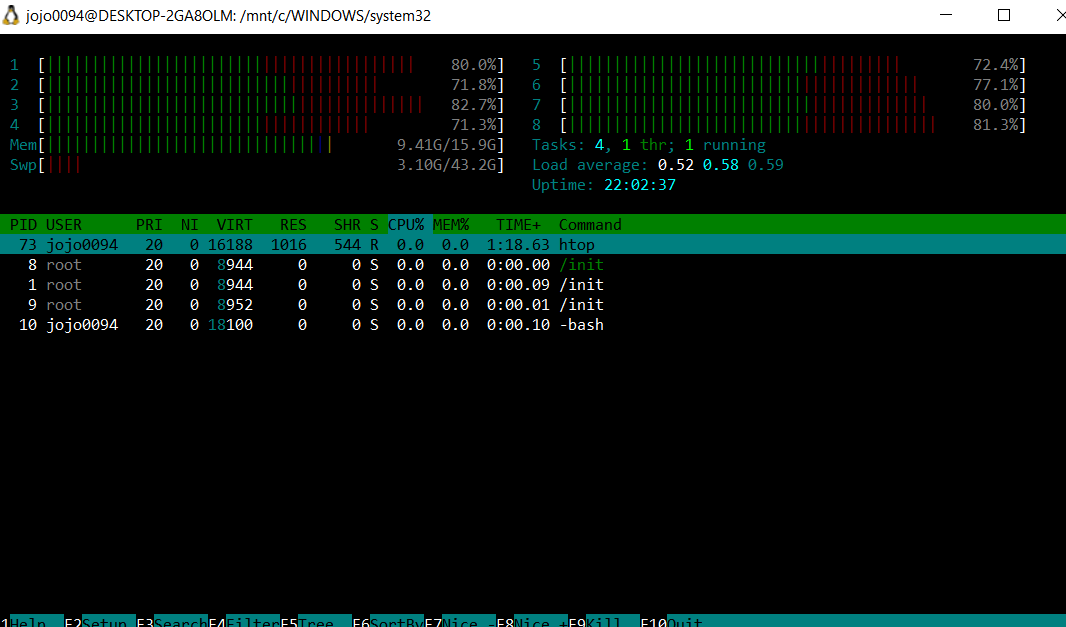

In [ ]:
%%time
for zone in individual_snapped_pts_dict:
    print(zone)
    d8_pntr = d8_ptr_dict[zone]
    #compute_list_ = []
    for number in individual_snapped_pts_dict[zone]:
        #z  = delayed(watershed_individual)(d8_pntr,individual_snapped_pts_dict[zone][number],zone,number)
        watershed_individual(d8_pntr,individual_snapped_pts_dict[zone][number],zone,number)
        #compute_list_.append(z)
    #dask.compute(*compute_list_)

In [ ]:
raw_polygon_dict = {}
for zone in zone_name:
    #print(zone)
    for number in os.listdir(os.path.join(mother_directory,'individual_watershed',zone)):
        #print(number)
        raw_polygon_dict[number[:-4][-3:]] = os.path.join(mother_directory,'individual_watershed',zone,number)
raw_polygon_dict

In [ ]:
raw_polygon_list = [os.path.join(mother_directory,'indivi',i) for i in [i for i in os.listdir(r'D:\FUTUREDAMS\dams_planned\nasa_watershed_pre') if '.tif' in i[-4:]]]

In [ ]:
def raster_to_polygon(raw_polygon):
    remove_file(os.path.join(mother_directory,'watershed_shape',raw_polygon+'.shp'))
    Path(os.path.join(mother_directory,'watershed_shape')).mkdir(parents=True, exist_ok=True)
    output = os.path.join(mother_directory,'watershed_shape',raw_polygon+'.shp')
    wbt.raster_to_vector_polygons(raw_polygon_dict[raw_polygon], output, callback=None)
    return None

In [ ]:
%%time
compute_polygon_list = []
for raw_polygon in raw_polygon_dict:
    print(raw_polygon)
    z = delayed(raster_to_polygon)(raw_polygon)
    compute_polygon_list.append(z)

In [ ]:
%time
dask.compute(*compute_polygon_list)

### There are some polygon (islands) inside the identifyed watershed shapefiles. Let us melt those into a single polygon.
- one example is as below
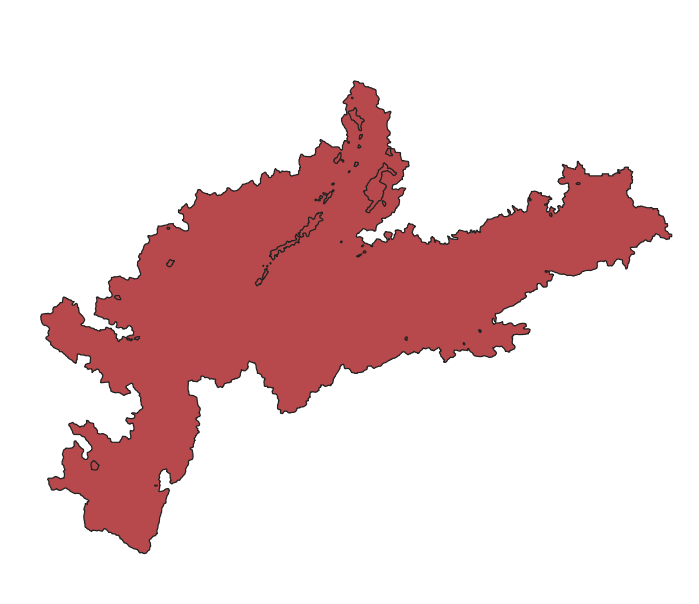

In [ ]:
watershed_shape_list = [os.path.join(mother_directory,'watershed_shape',i) for i in [i for i in os.listdir(os.path.join(mother_directory,
                                                                                                                       'watershed_shape')) if '.shp' in i[-4:]]]

In [ ]:
watershed_shape_dict = {}
for number in watershed_shape_list:
    #print(number[:-4][-3:])
    watershed_shape_dict[number[:-4][-3:]] = number
watershed_shape_dict

In [ ]:
def to_single_polygon(file,file_name):
    """get single polygon ,getting rid of islands"""
    remove_file(os.path.join(mother_directory,'watershed_shape_melt',file_name+'.shp'))
    Path(os.path.join(mother_directory,'watershed_shape_melt')).mkdir(parents=True, exist_ok=True)
    df_test = gpd.read_file(file)
    df_test['new_column'] = 0
    #df_test = df_test[df_test.pixelvalue!=0] ## cox we used wbt method which only frame the true extent
    df_test = df_test.dissolve(by='new_column')
    to_save = os.path.join(mother_directory,'watershed_shape_melt',file_name+'.shp')

    df_test.dissolve(by='new_column').to_file(to_save)
    return None

In [ ]:
watershed_melt_compute_list = []
for number in watershed_shape_dict:
    #print(number)
    z = delayed(to_single_polygon)(watershed_shape_dict[number],number)
    watershed_melt_compute_list.append(z)
    

In [ ]:
%%time

dask.compute(*watershed_melt_compute_list)

In [ ]:
watershed_shape_melt_list = [os.path.join(mother_directory,'watershed_shape_melt',i) for i in [i for i in os.listdir(os.path.join(mother_directory,
                                                                                                                       'watershed_shape_melt')) if '.shp' in i[-4:]]]

In [ ]:
watershed_shape_melt_dict = {}
for number in watershed_shape_melt_list:
    watershed_shape_melt_dict[number[:-4][-3:]] = number
watershed_shape_melt_dict

In [ ]:
%%time
#https://autogis-site.readthedocs.io/en/latest/notebooks/Raster/clipping-raster.html
#raster_path = os.path.join(mother_directory,'nasa_mosiac','original_resolution.tif')
raster_path = os.path.join(mother_directory,'nasa_mosiac','dem_downscaled.tif') ##using downscaled dataset
data = rasterio.open(raster_path)
epsg_code = int(data.crs.data['init'][5:])
epsg_string = pycrs.parse.from_epsg_code(epsg_code).to_proj4()
def clip_compute_2(geo,raster_path,i):
    """clip DEM of whole Myanmar into
    zonings in zone_list"""
    data = rasterio.open(raster_path)
    coords = getFeatures(geo)
    out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": epsg_string}
                            )
    Path(os.path.join(mother_directory,'dem_clipped_by_watershed')).mkdir(parents=True, exist_ok=True)
    out_tif = os.path.join(os.path.join(mother_directory,'dem_clipped_by_watershed'),i+'.tif')
    remove_file(out_tif)
    with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_img)
    return None

In [ ]:
%%time
compute_list_2 = []
for number in watershed_shape_melt_dict:
    #print(zone_dict[i])
    #print(number)
    geo = gpd.read_file(watershed_shape_melt_dict[number])
    geo.set_crs('epsg:4326')
    z = delayed(clip_compute_2)(geo,raster_path,number)
    compute_list_2.append(z)

In [ ]:
%%time
dask.compute(*compute_list_2)

## Finding inundated area (left the volume curve calculation atm)

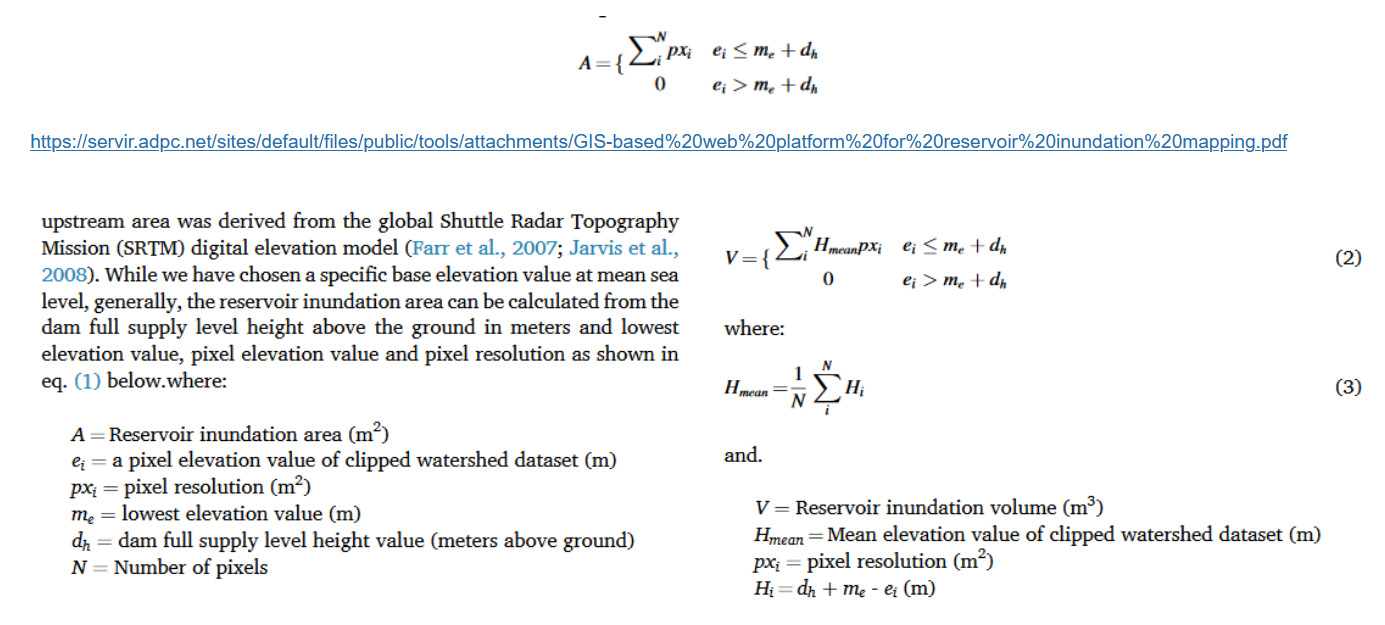

https://servir.adpc.net/sites/default/files/public/tools/attachments/GIS-based%20web%20platform%20for%20reservoir%20inundation%20mapping.pdf

In [ ]:
watershed_raster_list = [os.path.join(mother_directory,'dem_clipped_by_watershed',
                                      i) for i in [i for i in os.listdir(os.path.join(mother_directory,
                                                                                     'dem_clipped_by_watershed')) if '.tif' in i[-4:]]]

In [ ]:
%%time
watershed_raster_dict = {}
for number in watershed_raster_list:
    #testtt = rxr.open_rasterio(number,masked=True).squeeze()
    watershed_raster_dict[number[:-4][-3:]] = number
watershed_raster_dict

##we can give one more argument of the place to save later for the funtion later to avoid duplicated functions.
- filling/hydrologically correcting again to avoid segmented waterhshed area as below 
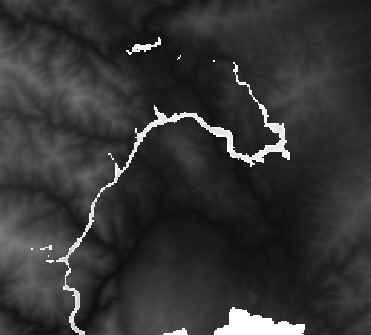

In [ ]:
##we can give one more argument of the place to save later for the funtion later to avoid duplicated functions
def filled_2 (file,watershed_raster_dict):
    """fill dem to enforce flow direction (i.e., make it 
    
    hydrologically correct)"""
    Path(os.path.join(mother_directory,'watershed_raster_filled')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(mother_directory,'watershed_raster_breached')).mkdir(parents=True, exist_ok=True)
    remove_file(os.path.join(mother_directory,'watershed_raster_filled',file+"_filled.tif"))
    wbt.fill_single_cell_pits(
                    dem = watershed_raster_dict[file],
                    output = os.path.join(mother_directory,'watershed_raster_filled',file+"_filled.tif"))
    remove_file(os.path.join(mother_directory,'watershed_raster_breached',file+"_breached.tif"))
    wbt.breach_depressions_least_cost(
                         dem = os.path.join(mother_directory,'watershed_raster_filled',file+"_filled.tif"),
                         output = os.path.join(mother_directory,'watershed_raster_breached',file+"_breached.tif"),
                         dist = 5,
                         fill = True)
    return None 

In [ ]:
filled_compute_2 = []
for file in watershed_raster_dict:
    #print(file)
    z = delayed(filled_2)(file,watershed_raster_dict)
    filled_compute_2.append(z)

In [ ]:
%%time
dask.compute(*filled_compute_2)

In [ ]:
watershed_raster_filled_list = [os.path.join(mother_directory,'watershed_raster_breached',
                                      i) for i in [i for i in os.listdir(os.path.join(mother_directory,
                                                                                     'watershed_raster_breached')) if '.tif' in i[-4:]]]

In [ ]:
watershed_raster_filled_list

In [ ]:
%%time
watershed_raster_filled_dict = {}
for number in watershed_raster_filled_list:
    testtt = rxr.open_rasterio(number,masked=True).squeeze()
    watershed_raster_filled_dict[number[:-13][-3:]] = testtt
watershed_raster_filled_dict

In [ ]:
dams

In [ ]:
def extract_inundated_area(gdf,watershed_raster_filled_dict,ID) -> None:
    remove_file(os.path.join(mother_directory,'inundated_raster_constant',str(ID)+'.tif'))
    Path(os.path.join(mother_directory,'inundated_raster_constant')).mkdir(parents=True, exist_ok=True)

    remove_file(os.path.join(mother_directory,'inundated_raster',str(ID)+'.tif'))
    Path(os.path.join(mother_directory,'inundated_raster')).mkdir(parents=True, exist_ok=True)

    final = watershed_raster_filled_dict[str(ID)].where(watershed_raster_filled_dict[ID]<=(gdf[gdf.ID==int(ID)].DAM_HEIGHT.values+watershed_raster_filled_dict[ID].min().values),drop=True)
    file_name = os.path.join(mother_directory,'inundated_raster',str(ID)+'.tif')
    final.rio.to_raster(file_name,masked=False,dtype="uint16")
    """the following second part is to simpify raster-to-polygon process"""
    final_2 = watershed_raster_filled_dict[str(ID)].where(~(watershed_raster_filled_dict[ID]<=(gdf[gdf.ID==int(ID)].DAM_HEIGHT.values+watershed_raster_filled_dict[ID].min().values)),other=100)
    final_2 = final_2.where(final_2==100,other=np.nan)
    file_name_2 = os.path.join(mother_directory,'inundated_raster_constant',str(ID)+'.tif')
    final_2.rio.to_raster(file_name_2,masked=True,dtype="uint16") 

In [ ]:
inundated_compute_list  = []
for i in watershed_raster_filled_dict:
    #print(i)
    
    z = delayed(extract_inundated_area)(dams,watershed_raster_filled_dict,i)
    inundated_compute_list.append(z)

In [ ]:
%%time
dask.compute(*inundated_compute_list)

## to check the algorithm please use GIS software to indentiy, 
### no matter how far upstream the area is stretching like in the case of 199. 
i.e check where the clicked pixel values is less than dam height + the dem value at the dam location (snapped pts)

In [ ]:
print("maximum values for ID 199 should be",dams[dams.ID==int(199)].DAM_HEIGHT.values+watershed_raster_filled_dict[str(199)].min().values)
print("and dam height is is ",dams[dams.ID==int(199)].DAM_HEIGHT.values)
print("and minimum, is ",watershed_raster_filled_dict[str(199)].min().values)

## please find the raster values of at the edge (upstream) which should be no more than dam height + dem values at the snapped point (pour point)

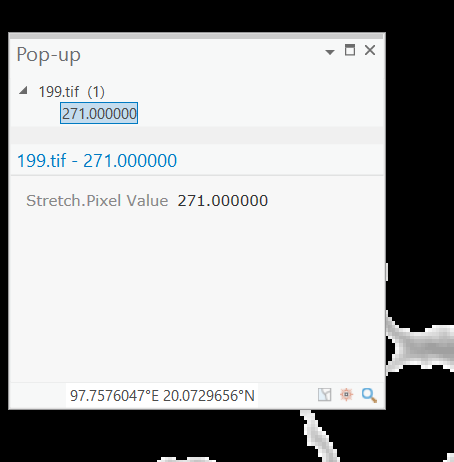

In [ ]:
print("maximum values for ID 105 should be",dams[dams.ID==int(105)].DAM_HEIGHT.values+watershed_raster_filled_dict[str(105)].min().values)
print("and dam height is ",dams[dams.ID==int(105)].DAM_HEIGHT.values)
print("and minimu, is ",watershed_raster_filled_dict[str(105)].min().values)

ID 105 also agree. 
## Therefore, let us assume the algorithm is correct. 
If values are not sensible, please open original DEM data and inspect the DEM values at the points where you would normally test with the inudnated raster
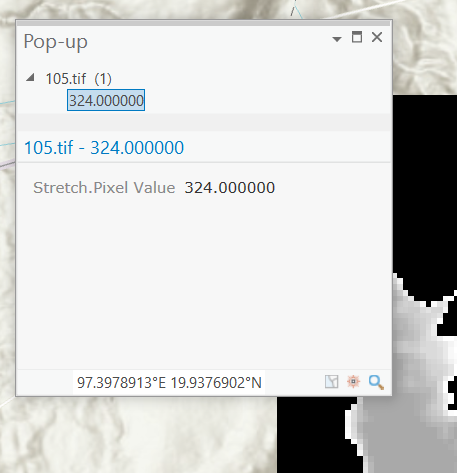

### Raster to polygon 

In [ ]:
inundated_raster_list = [os.path.join(mother_directory,'inundated_raster_constant',
                                      i) for i in [i for i in os.listdir(os.path.join(mother_directory,
                                                                                     'inundated_raster_constant')) if '.tif' in i[-4:]]]

In [ ]:
inundated_raster_dict = {}
for number in inundated_raster_list:
    #print(number[:-4][-3:])
    inundated_raster_dict[number[:-4][-3:]] = number
inundated_raster_dict

In [ ]:
def raster_to_polygon_2(raw_polygon,inundated_raster_dict) -> None:
    remove_file(os.path.join(mother_directory,'inundated_shp',raw_polygon+'.shp'))
    Path(os.path.join(mother_directory,'inundated_shp')).mkdir(parents=True, exist_ok=True)
    output = os.path.join(mother_directory,'inundated_shp',raw_polygon+'.shp')
    wbt.raster_to_vector_polygons(inundated_raster_dict[raw_polygon], output, callback=None)

In [ ]:
%%time
inundated_shp_compute_list = []
for raw_polygon in inundated_raster_dict:#inundated_raster_list:
    z = delayed(raster_to_polygon_2)(raw_polygon,inundated_raster_dict)
    inundated_shp_compute_list.append(z)

In [ ]:
%%time 
dask.compute(*inundated_shp_compute_list)

### inundated shapefiles consists of little islands and mutliple polygons. We will make it into a single one.
- Little islands are due to really sharp/hight topography (you can check with topography basemap)
- Single polygon without little island makes sense for the case of relocations/resettle issues of inundated villages
- But the sharp/high island consist of high-potential for GHG calculation. I suggest to use results from 'inundated shp' folder.
- In this work, I will proceed with single polygon.

In [ ]:
inundated_shp_list = [os.path.join(mother_directory,'inundated_shp',
                                      i) for i in [i for i in os.listdir(os.path.join(mother_directory,
                                                                                     'inundated_shp')) if '.shp' in i[-4:]]]
inundated_shp_dict = {}
for number in inundated_shp_list:
    inundated_shp_dict[number[:-4][-3:]] = number
inundated_shp_dict

In [ ]:
def to_single_polygon(file_name: str, inudated_shp_dict: dict) -> None:
    """ """
    remove_file(os.path.join(mother_directory,'inundated_shp_single',file_name+'.shp'))
    Path(os.path.join(mother_directory,'inundated_shp_single')).mkdir(parents=True, exist_ok=True)
    df_test = gpd.read_file(inundated_shp_dict[file_name])
    df_test['new_column'] = 0
    df_test = df_test.dissolve(by='new_column')
    to_save = os.path.join(mother_directory,
                           'inundated_shp_single',file_name+'.shp')
    df_test.dissolve(by='new_column').to_file(to_save)

In [ ]:
polygon_fill_compute_list = []
for name in inundated_shp_dict:
    #print(name)
    z = delayed(to_single_polygon)(name,inundated_shp_dict)
    polygon_fill_compute_list.append(z)

In [ ]:
%%time 
dask.compute(*polygon_fill_compute_list)

### Remove polygon holes (no need atm)

In [ ]:
%%time
#import geopandas

folder = Path(os.path.join(mother_directory,
                          'inundated_shp_single'))
shapefiles = folder.glob("*.shp")
gdf_inundated = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
#gdf.index = [int(i[:-4]) for i in os.listdir(folder) if '.shp' in i]
gdf_inundated.index=[int(i[:-4]) for i in os.listdir(folder) if '.shp' in i]
gdf_inundated.new_column= gdf_inundated.index.to_list()
gdf_inundated.set_crs('epsg:4326')
print(gdf_inundated.crs) ##setting Coordinate Ref system does not work here, Dont knnow why.

In [ ]:
gdf_inundated.crs

In [ ]:
dams.columns

## Concating with IFC information.

In [ ]:
test__ = copy.deepcopy(dams) ##sort IFC dataframe first by ID values
test__.sort_values('ID')
df_toconcat = dams[['ID', 'GRAND_ID', 'GOOD_ID', 'IFC_ID', 'DAM_NAME', 'Status', 'Status 2',
       'LAT N', 'LON E', 'State/Regi', 'District', 'Township', 'Village',
       'Basin', 'Sub-Basin', 'Sub-Basi_1', 'Watershed', 'HP or Mult',
       'DAM_HEIGHT', 'FSL (m)', 'LWL (m)', 'Drawdown', 'Area(km2)', 'Len(km)',
       'Dead_Sto', 'Live_Sto', 'HRT', 'RoR or Sto', 'Des_Disch', 'Des_Head',
       'No_turb', 'Inst_cap', 'Annual Gen', 'Firm Power', 'TL Connect',
       'Developer', 'Country', 'Investment', 'Selfuse', '% use MYA',
       'Export_MW', 'Export to', 'Estimated', 'Actual Com', 'Comm_plan',
       'GOID', 'STOR_MCM', 'BAS_ID', 'BAS_NAME', 'RIV_ORD', 'HYBAS_ID',
       'Source', 'ALT_NAME', 'RIVER', 'NEAR_CITY', 'ALT_CITY', 'YEAR',
       'ALT_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'AREA_POLY', 'AREA_REP',
       'CAP_REP', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
       'USE_IRRI', 'USE_ELEC', 'USE_SUPP', 'MAIN_USE', 'COMMENTS', 'Hylak_id',
       'Lake_type', 'Lake_area', 'Shore_len', 'Shore_dev', 'Depth_avg',
       'Dis_avg', 'Res_time', 'Elevation', 'Slope_100', 'Wshd_area',
       'ALT_RIVER', 'ADMIN_UNIT', 'SEC_ADMIN', 'ALT_YEAR', 'DAM_HGT_M',
       'ALT_LEN_M', 'INC', 'Comment']]
for i in df_toconcat.columns:
    #print(i)
    gdf_inundated[i] = test__[i].to_list()
gdf_inundated.to_file(os.path.join(mother_directory,'combined_inundated_shp_no_crs.shp'))


## Checking with the IFC maximum reservoir area. 
- I firstly set the crs in GIS software for 'combined_inundated_shp_no_crs.shp' first

In [ ]:
final_shp = gpd.read_file(os.path.join(mother_directory,'final_inundated_shp_2','combined_inundated_shp_no_crs.shp'))

In [ ]:
final_shp.crs ##this is used for direct calculation of area

In [ ]:
final_shp[final_shp.ID==135].area/(10**6)

In [ ]:
final_shp.columns

In [ ]:
final_shp[['ID','Area_km2_','Lake_area','AREA_SKM','AREA_POLY','AREA_REP','Wshd_area']]



##very likely Area_km2_ is what we need to compare. This is also confirmed by the website for dam database.
- IFC lacks many P or C (planned and during construction status dams) from that website and vice versa.
- There were iterations of dam informations for dam height and locations according to that website.https://damtool-servir.adpc.net/ 
- IWMI is still in the process of data inquiry from that website (cox currently ours resutls do not match for most of the dams)
- based on the algorithm checking in GIS. the DEM values of inudated area complies with "less than dam height + dem values at the dam locations"

In [ ]:
for ID in final_shp.ID:
    df = final_shp[final_shp.ID==ID]
    print('IFC area: ',df['Area_km2_'].values[0],'ours: ',df.area/(10**6))